In [123]:
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
import numpy as np
import re
import seaborn as sns
import warnings
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Documentation:

* nltk: https://www.nltk.org/
* Textblob: https://textblob.readthedocs.io/en/dev/
* wordcloud: https://amueller.github.io/word_cloud/

In [124]:
data = pd.read_csv('data/msft_dataworldnews_stocks_investing.csv')
data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Index,MSFT.Adjusted,worldnews,stocks,investing
0,0,0,0,2022-01-03,328.727661,1 Feb 2016 — Find the best posts and communiti...,"Since a new year has started, I have summed up...","Since a new year has started, I have summed up..."
1,1,1,1,2022-01-04,323.090942,"In Portugal, with 89% of the total population ...",Looking for friends? Let us know what Support ...,This thread is for any and all basic gameplay ...
2,2,2,2,2022-01-05,310.688141,18 Mar 2021 — Find the best posts and communit...,What are the raw materials? Financials? Health...,"Hi, welcome to r/investing. Please note that a..."
3,3,3,3,2022-01-06,308.233124,And yet pro israelis and islamophobes are allo...,UPDATE1: Etoro response on 2021-12-31 HERE. UP...,I'm curious how current retirees transitioned ...
4,4,4,4,2022-01-07,308.390289,I've taken several rapid tests (4 total at var...,12 Aug 2021 — Find the best posts and communit...,12 Aug 2021 — Find the best posts and communit...


## Text Cleaning

In [125]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text) 
    return text

def clean_text(text):
    text = re.sub(r"@[A-Za-z0–9]+", "", text) # Remove @mentions replace with blank
    text = re.sub(r"#", "", text) # Remove the ‘#’ symbol, replace with blank
    text = re.sub(r"RT[\s]+", "", text) # Removing RT, replace with blank
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove the hyperlinks
    text = re.sub(r":", "", text) # Remove :
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [126]:
# stopword removal
# not sure if needed it might have a negative impact on the sentiment analysis 

def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

## trial code for one column before building th function

```python
### remove the date from the beginning of some test
data['worldnews'] = data['worldnews'].str.replace(r'\b\d{1,2} \w+ \d{4}\b', '', regex=True)
### remove subreddit names like r/worldnews, r/stocks
data['worldnews'] = data['worldnews'].str.replace(r"r/[A-Za-z0-9]+ -", '', regex=True)

data['worldnews'] = data['worldnews'].apply(strip_html_tags)
data['worldnews'] = data['worldnews'].apply(remove_accented_chars)
data['worldnews'] = data['worldnews'].apply(remove_special_characters)

### remove sentences that start with "Find the best posts and communities about..."
data['worldnews'] = data['worldnews'].str.replace(r'Find the best posts and communities about.*?\.', '', regex=True)
data['worldnews'] = data['worldnews'].str.replace(r"reReddit Top posts of [A-Za-z]+ [0-9]{4} Reddit\.", '', regex=True) 
data['worldnews'] = data['worldnews'].str.replace(r"\s*Reddit\s*reReddit\s*Top\s*posts\s*of\s*(?:January|February|March|April|May|June|July|August|September|October|November|December)\s*\d{4}\s*Reddit\s*reReddit\s*Top\s*", '', regex=True)

data['worldnews'] = data['worldnews'].apply(clean_text)
data['worldnews'] = data['worldnews'].apply(remove_emojis)
```

In [137]:
def clean_column(df, column_name):
    # remove the date from the beginning of some test
    df[column_name] = df[column_name].str.replace(r'\b\d{1,2} \w+ \d{4}\b', '', regex=True)
    # remove subreddit names like r/worldnews, r/stocks
    df[column_name] = df[column_name].str.replace(r"r/[A-Za-z0-9]+ -", '', regex=True)

    df[column_name] = df[column_name].apply(strip_html_tags)
    df[column_name] = df[column_name].apply(remove_accented_chars)
    df[column_name] = df[column_name].apply(remove_special_characters)

    # remove sentences that start with "Find the best posts and communities about..."
    df[column_name] = df[column_name].str.replace(r'Find the best posts and communities about.*?\.', '', regex=True)
    df[column_name] = df[column_name].str.replace(r"reReddit Top posts of [A-Za-z]+ [0-9]{4} Reddit\.", '', regex=True) 
    df[column_name] = df[column_name].str.replace(r"\s*Reddit\s*reReddit\s*Top\s*posts\s*of\s*(?:January|February|March|April|May|June|July|August|September|October|November|December)\s*\d{4}\s*Reddit\s*reReddit\s*Top\s*", '', regex=True)

    df[column_name] = df[column_name].apply(clean_text)
    df[column_name] = df[column_name].apply(remove_emojis)

    return df

In [138]:
data = clean_column(data, 'worldnews')
data = clean_column(data, 'stocks')
data = clean_column(data, 'investing')

In [139]:
data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Index,MSFT.Adjusted,worldnews,stocks,investing,Subjectivity_worldnews,Polarity_worldnews,Sentiment_worldnews,Subjectivity_stocks,Polarity_stocks,Sentiment_stocks,Subjectivity_investing,Polarity_investing,Sentiment_investing
0,0,0,0,2022-01-03,328.727661,Find the best posts and communities about Pr...,Since a new year has started I have summed up ...,Since a new year has started I have summed up ...,0.416667,0.206944,Positive,0.603555,-0.015793,Negative,0.462121,-0.023030,Negative
1,1,1,1,2022-01-04,323.090942,In Portugal with 89 of the total population fu...,Looking for friends Let us know what Support S...,This thread is for any and all basic gameplay ...,0.511364,0.310909,Positive,0.338095,-0.123810,Negative,0.312949,0.110000,Positive
2,2,2,2,2022-01-05,310.688141,Find the best posts and communities about Be...,What are the raw materials Financials Healthca...,Hi welcome to rinvesting Please note that as a...,0.316667,0.058333,Positive,0.335775,0.087668,Positive,0.497086,0.215559,Positive
3,3,3,3,2022-01-06,308.233124,And yet pro israelis and islamophobes are allo...,UPDATE1 Etoro response on 20211231 HERE UPDATE...,Im curious how current retirees transitioned t...,0.448788,0.096136,Positive,0.317500,-0.032500,Negative,0.371429,-0.035714,Negative
4,4,4,4,2022-01-07,308.390289,Ive taken several rapid tests 4 total at vario...,Find the best posts and communities about NA...,Find the best posts and communities about NA...,0.321402,0.129545,Positive,0.452381,0.445238,Positive,0.199038,0.237179,Positive


In [132]:
def Subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def Polarity(text):
    return TextBlob(text).sentiment.polarity

def Sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [140]:
# Now we create a new column for what we just did and add it to the Tweet_df dataframe

data['Subjectivity_worldnews'] = data['worldnews'].apply(Subjectivity)
data['Polarity_worldnews'] = data['worldnews'].apply(Polarity)
data['Sentiment_worldnews'] = data['Polarity_worldnews'].apply(Sentiment)

data['Subjectivity_stocks'] = data['stocks'].apply(Subjectivity)
data['Polarity_stocks'] = data['stocks'].apply(Polarity)
data['Sentiment_stocks'] = data['Polarity_stocks'].apply(Sentiment)

data['Subjectivity_investing'] = data['investing'].apply(Subjectivity)
data['Polarity_investing'] = data['investing'].apply(Polarity)
data['Sentiment_investing'] = data['Polarity_investing'].apply(Sentiment)

data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Index,MSFT.Adjusted,worldnews,stocks,investing,Subjectivity_worldnews,Polarity_worldnews,Sentiment_worldnews,Subjectivity_stocks,Polarity_stocks,Sentiment_stocks,Subjectivity_investing,Polarity_investing,Sentiment_investing
0,0,0,0,2022-01-03,328.727661,Find the best posts and communities about Pr...,Since a new year has started I have summed up ...,Since a new year has started I have summed up ...,0.416667,0.206944,Positive,0.603555,-0.015793,Negative,0.462121,-0.023030,Negative
1,1,1,1,2022-01-04,323.090942,In Portugal with 89 of the total population fu...,Looking for friends Let us know what Support S...,This thread is for any and all basic gameplay ...,0.511364,0.310909,Positive,0.338095,-0.123810,Negative,0.312949,0.110000,Positive
2,2,2,2,2022-01-05,310.688141,Find the best posts and communities about Be...,What are the raw materials Financials Healthca...,Hi welcome to rinvesting Please note that as a...,0.316667,0.058333,Positive,0.335775,0.087668,Positive,0.497086,0.215559,Positive
3,3,3,3,2022-01-06,308.233124,And yet pro israelis and islamophobes are allo...,UPDATE1 Etoro response on 20211231 HERE UPDATE...,Im curious how current retirees transitioned t...,0.448788,0.096136,Positive,0.317500,-0.032500,Negative,0.371429,-0.035714,Negative
4,4,4,4,2022-01-07,308.390289,Ive taken several rapid tests 4 total at vario...,Find the best posts and communities about NA...,Find the best posts and communities about NA...,0.321402,0.129545,Positive,0.452381,0.445238,Positive,0.199038,0.237179,Positive


In [141]:
data.Sentiment_worldnews.value_counts()

Sentiment_worldnews
Positive    426
Negative     53
Neutral       2
Name: count, dtype: int64

(-0.5, 999.5, 599.5, -0.5)

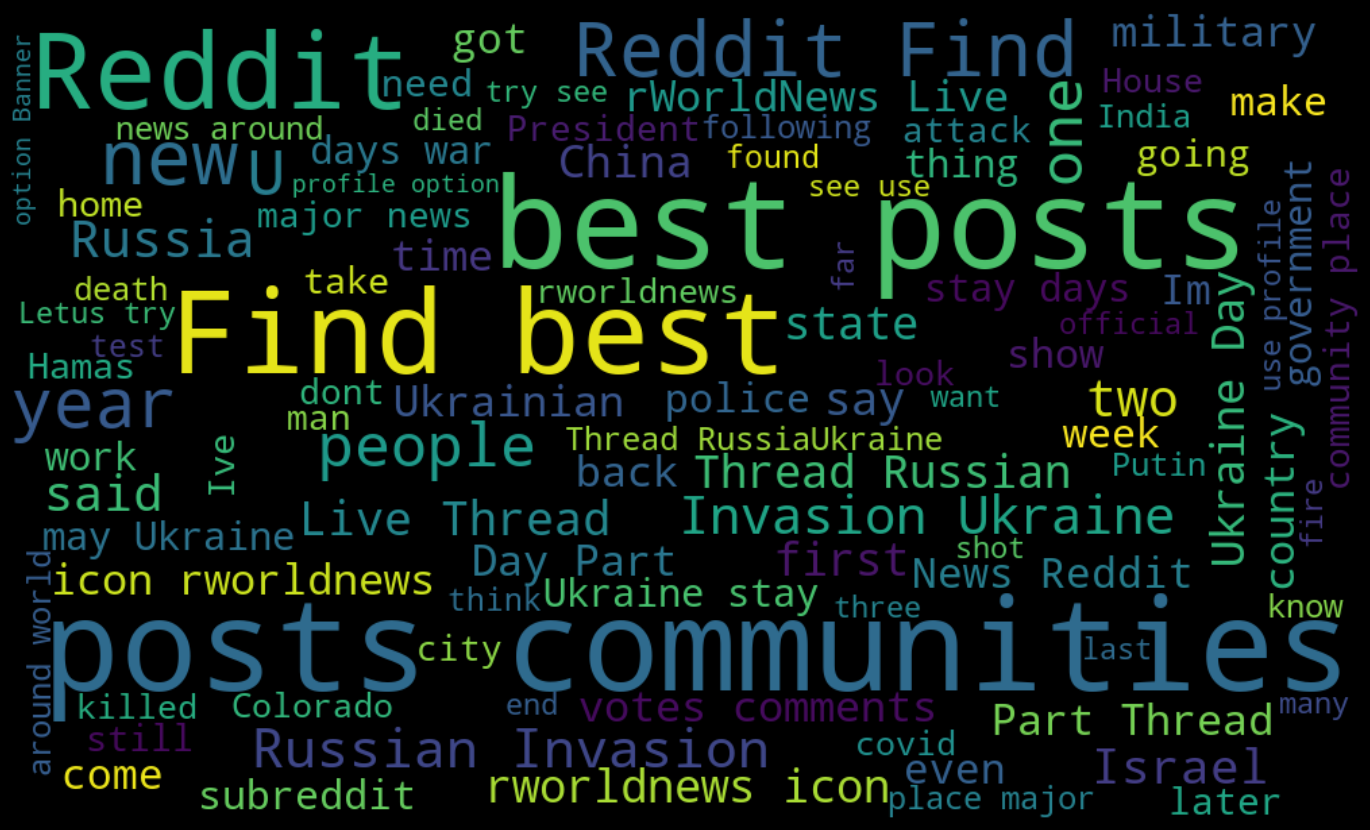

In [136]:
viz_data = data.copy(deep=True)

viz_data['worldnews'] = viz_data['worldnews'].apply(remove_stopwords) #removing stop words for visualizations only because it reduced the polarity for some text

text = ''.join( [post for post in viz_data['worldnews']] ) #To join all posts

# generate word cloud 
stopwords = STOPWORDS
wordcloud = WordCloud(width=1000, height = 600, 
                      max_words = 100,
                      stopwords = stopwords,
                      background_color='black').generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
# TODO create average for all the columns in terms of polarity

In [ ]:
msft_data2.to_csv('data/msft_dataworldnews_stocks.csv')